## Aim: Understand distribution of samples in training set (and subsequently in neighbourhoods of latent space)


In [1]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

# Reload modules
from importlib import reload
import util
import model
import value_decoder
import decoder
import encoder
import data_util
reload(util)
reload(model)
reload(value_decoder)
reload(decoder)
reload(encoder)
reload(data_util)

/Users/luis/opt/anaconda3/envs/simexpr-arm64/lib/python3.12/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/Users/luis/opt/anaconda3/envs/simexpr-arm64/lib/python3.12/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


<module 'data_util' from '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/model/data_util.py'>

In [2]:
import torch
import numpy as np
import sympy as sp
import pandas as pd
from data_util import load_wandb_model, create_dataloader_from_wandb, data_from_loader
from debug_util import plot_var_distributions, plot_latent_distribution
from matplotlib import pyplot as plt
from typing import Union, List, Dict
from tqdm import tqdm
import ipywidgets as widgets
import torch.nn.functional as F
torch.manual_seed(42)
torch.set_grad_enabled(False)

SIMILARITY_THRESHOLD = 1e-3

## 1. Check distribution of samples around a single sample (in y space)

- Take single sample from training set and compare the other samples to it (in y)
- Repeat for multiple samples to be more robust
- Using dataloaders from wandb run (easiest for now)

In [3]:
from data_util import create_dataloader
from util import load_config
datapath = '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/data'
name = 'dataset_241223_1'

cfg = load_config('../model/config.yaml', fallback_cfg_path='../model/config.yaml')

train_loader, valid_loader, info = create_dataloader(datapath, name, cfg, random_seed=0, shuffle_train=False, value_transform=lambda x: x)  # Using datasets with data already normalised
val_x, syntax_cats, value_transform = info['val_x'], info['syntax_cats'], info['value_transform']

### 1.1 Compare target expression graph to rest of training set

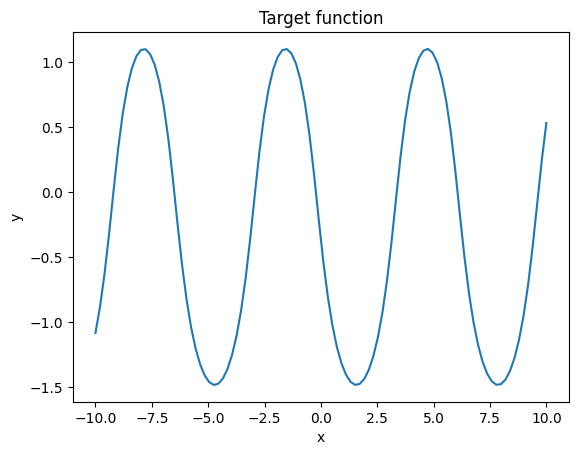

In [8]:
target_idx = 0
data_loader = train_loader  # FIXME: Only works with train_loader currently...
values_target = data_from_loader(data_loader, 'values', idx=target_idx)  

plt.plot(val_x.squeeze(), values_target.squeeze().detach().numpy())
plt.title('Target function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [9]:
# Calculate MSE to target for all samples in training set

N = 2**21
BATCH_SIZE = 2**7  # 16
data_loader = train_loader

N = (min(len(data_loader.dataset), N) // BATCH_SIZE) * BATCH_SIZE  # Round down to nearest batch size
dist_y = torch.ones(N)
for i, values in tqdm(enumerate(data_from_loader(data_loader, 'values', batch_size=BATCH_SIZE, max_length=N)), total=N//BATCH_SIZE):
    assert values.isnan().sum() == 0, 'NaN values in dataset'
    dist_y[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = torch.mean((values - values_target)**2, dim=1)  # MSE

mse_sorted = pd.Series(dist_y).sort_values()

100%|██████████| 70/70 [00:00<00:00, 1071.32it/s]


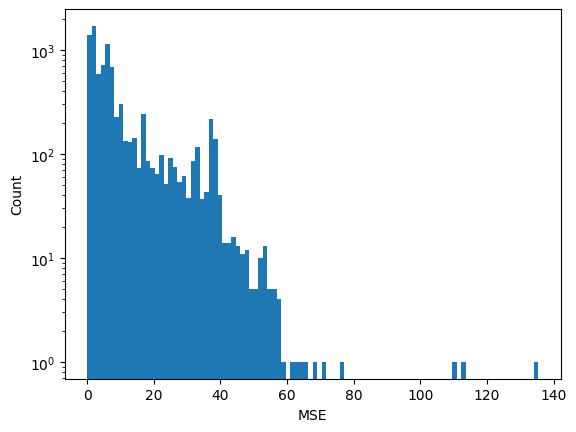

In [10]:
# Plot distribution of MSEs
plt.hist(dist_y.detach().numpy(), bins=100)
plt.xlabel('MSE')
plt.ylabel('Count')
plt.yscale('log')
plt.show()


In [11]:
# Plot sample with a specific MSE to target (to get an idea for meaning of magnitude of MSE)

mse_wanted = widgets.FloatLogSlider(
    value=3e-5,
    min=-7,
    max=np.log10(mse_sorted.iloc[-1]),
    step=0.1,
    base=10,
    description='MSE Target:',
    continuous_update=False
)

max_mse = widgets.FloatLogSlider(
    value=1e-3, 
    min=-7,
    max=np.log10(mse_sorted.iloc[-1]),
    step=0.1,
    base=10,
    description='Max MSE:',
    continuous_update=False
)

def update_plot(mse_target, mse_max):
    idx = (pd.Series(dist_y) - mse_target).abs().idxmin()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left subplot - histogram
    counts, bins = np.histogram(dist_y.detach().numpy(), bins=100, range=(0, mse_max))
    ax1.bar(bins[:-1], counts, width=np.diff(bins), align='edge')
    ax1.axvline(x=mse_target, color='r', linestyle='--')
    ax1.set_yscale('log')
    ax1.set_xlabel('MSE')
    ax1.set_ylabel('Count')
    
    # Right subplot - function comparison
    ax2.plot(val_x.squeeze(), values_target.squeeze().detach().numpy(), label='Target', color='r')
    ax2.plot(val_x.squeeze(), data_from_loader(data_loader, 'values', idx=idx).squeeze().detach().numpy(), 
             label=f'MSE: {dist_y.detach().numpy()[idx]:.2e}')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

widgets.interactive(update_plot, 
                   mse_target=mse_wanted,
                   mse_max=max_mse)

interactive(children=(FloatLogSlider(value=3e-05, continuous_update=False, description='MSE Target:', max=2.13…

### 1.2 Calculate number of similar expressions in training set

In [23]:
# Calculate number of similar samples for a couple of examples
# Compare similarity of n targets to m samples

n, m = 512, int(1e6)
BATCH_SIZE = 4
n = (n // BATCH_SIZE) * BATCH_SIZE  # Round down to nearest batch size

print(f'Memory used: {BATCH_SIZE*m*100/2e9:.2f} GB')
print(f'Using {m/len(train_loader.dataset):.2f} of dataset')
assert BATCH_SIZE*m*100 < 4e9, 'Memory limit exceeded (limit is 4GB)'
  
values_samples = data_from_loader(train_loader, 'values', max_length=m)

similar_count = torch.empty(n)
for i, values_target in tqdm(enumerate(data_from_loader(train_loader, 'values', batch_size=BATCH_SIZE, max_length=n)), total=n//BATCH_SIZE, desc='Calculating similarity scores'):
    # Calculate MSE between each target and sample
    # Reshape to allow broadcasting: (n,points,1) - (m,1,points) -> (n,m)
    mse = torch.mean(
        (values_target.unsqueeze(1) - values_samples.unsqueeze(0))**2, 
        dim=2
    )
    similar_count[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = (mse < SIMILARITY_THRESHOLD).sum(dim=1)

Memory used: 0.20 GB
Using 0.54 of dataset


Calculating similarity scores: 100%|██████████| 128/128 [00:31<00:00,  4.07it/s]


/var/folders/kn/k8zt16ss511gp4m6y14ttn840000gn/T/ipykernel_22660/3465354401.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  hist, bins = np.histogram(similar_count.numpy(), bins=np.logspace(np.log10(similar_count.min()), np.log10(similar_count.max()), 40))


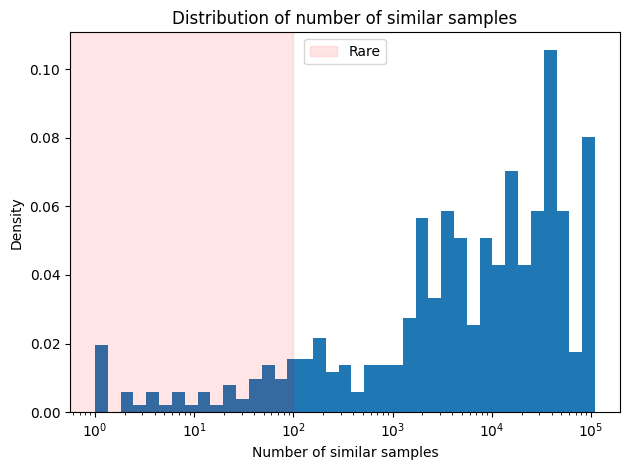

In [39]:
hist, bins = np.histogram(similar_count.numpy(), bins=np.logspace(np.log10(similar_count.min()), np.log10(similar_count.max()), 40))
hist = hist / hist.sum()

plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge')
plt.axvspan(xmin=0, xmax=100, color='r', alpha=0.1, label='Rare')
plt.title('Distribution of number of similar samples')
plt.xscale('log')
plt.xlabel('Number of similar samples')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## 2. Check distribution of training samples in latent space

(- will later do this for valid/random samples)
- Use different distance metrics: L2 and dot product, cosine similarity (currently using dot product for contrastive loss)

1. Plot distribution of z-dist for for different y-dist (MSE) (e.g. all within +-1e-3)
2. Plot distribution of z-dist for all samples with y-dist < threshold

3. Having defined that the expressions below threshold are the ones we are interested in, check how many communities there are. Use some spatial community detection in z using only expressions below threshold.

- For all points above, be careful as there might be large differences between target samples. Might want to repeat for multiple targets.

In [12]:
# Load model and dataset
model, cfg = load_wandb_model(run='zwrgtnj0', name='last.ckpt', project='simexp-03', replace=True, fallback_cfg_path='../model/config.yaml')
train_loader, test_loader, info = create_dataloader_from_wandb(cfg)
val_x, syntax_cats, value_transform = info['val_x'], info['syntax_cats'], info['value_transform']

Imported model from run "zwrgtnj0".
  | Name    | Type    | Params | Mode
-------------------------------------------
0 | encoder | Encoder | 8.9 M  | eval
1 | decoder | Decoder | 8.7 M  | eval
-------------------------------------------
17.6 M    Trainable params
0         Non-trainable params
17.6 M    Total params
70.298    Total estimated model params size (MB)
0         Modules in train mode
78        Modules in eval mode
Using dataset "dataset_241204_2" of size 1840811
DataLoader Summary
---------------------------------------------------------------------
  | Train        | Size: 1840811 | Batch: 512   | Batches: 3595 
  | valid        | Size: 204534  | Batch: 512   | Batches: 399  
---------------------------------------------------------------------


### 2.1 Compare latent space distance of target to rest of training set

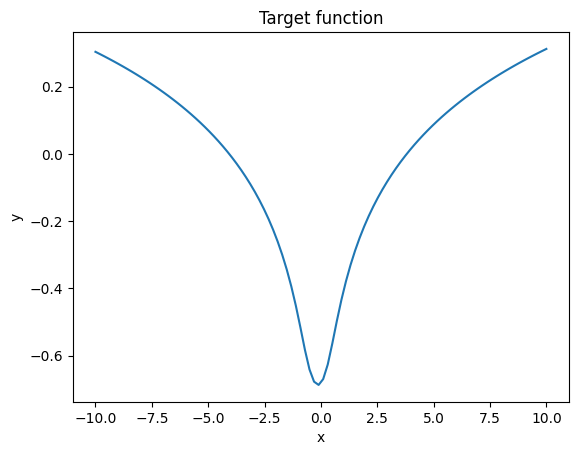

In [13]:
target_idx = 5
values_target = data_from_loader(train_loader, 'values', idx=target_idx)  
z_target = model.encoder(data_from_loader(train_loader, 'x', idx=target_idx))[0]

plt.plot(val_x.squeeze(), values_target.squeeze().detach().numpy())
plt.title('Target function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [14]:
# Calculating z and y distances for all samples in training set

N = 2**19
BATCH_SIZE = 2**15  # 15
N = (min(len(train_loader.dataset), N) // BATCH_SIZE) * BATCH_SIZE  # Round down to nearest batch size

values = data_from_loader(train_loader, 'values', max_length=N)

l2_dist_func = torch.nn.PairwiseDistance(p=2)

z_dist = torch.empty(N, 3)
for i, x in tqdm(enumerate(data_from_loader(train_loader, 'x', batch_size=BATCH_SIZE, max_length=N)), total=N//BATCH_SIZE, desc='Calculating z distances'):
    mean, ln_var = model.encoder(x)

    # l2_dist = torch.norm(mean - z_target, dim=1)
    l2_dist_fn = l2_dist_func(mean, z_target)
    cos_sim = F.cosine_similarity(mean, z_target)
    dot_prod = torch.sum(mean * z_target, dim=1)
    
    z_dist[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = torch.stack([l2_dist_fn, cos_sim, dot_prod], dim=1)

y_dist = torch.mean((values - values_target)**2, dim=1)  # MSE, before: 

# plt.hist(z_dist[:, 0].detach().numpy(), bins=100)
# plt.show()

Calculating z distances: 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


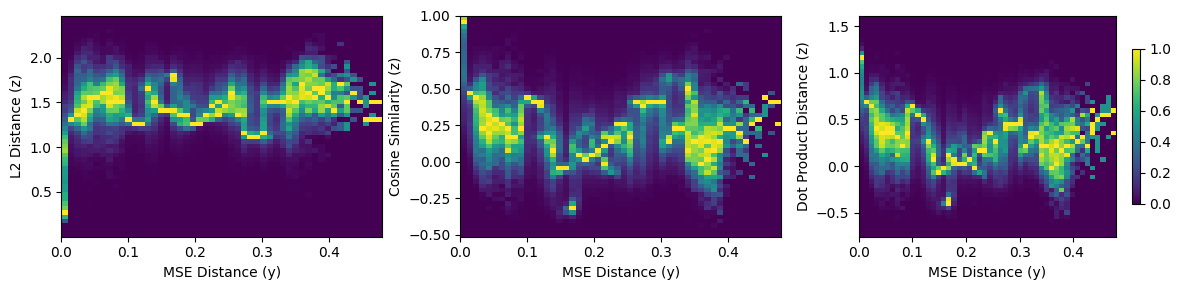

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

# L2 Distance
h1, xedges, yedges, im1 = ax1.hist2d(y_dist.numpy(), z_dist[:, 0].numpy(), bins=50, cmap='viridis')
h1 = h1 / h1.max(axis=1, keepdims=True)  # Normalize each column
im1.set_array(h1.T)
im1.set_clim(0, h1.max())  # Set colormap range from 0 to 1
ax1.set_xlabel('MSE Distance (y)')
ax1.set_ylabel('L2 Distance (z)')

# Cosine Similarity 
h2, xedges, yedges, im2 = ax2.hist2d(y_dist.numpy(), z_dist[:, 1].numpy(), bins=50, cmap='viridis')
h2 = h2 / h2.max(axis=1, keepdims=True)  # Normalize each column
im2.set_array(h2.T)
im2.set_clim(0, h2.max())  # Set colormap range from 0 to 1
ax2.set_xlabel('MSE Distance (y)')
ax2.set_ylabel('Cosine Similarity (z)')

# Dot Product
h3, xedges, yedges, im3 = ax3.hist2d(y_dist.numpy(), z_dist[:, 2].numpy(), bins=50, cmap='viridis')
h3 = h3 / h3.max(axis=1, keepdims=True)  # Normalize each column
im3.set_array(h3.T)
im3.set_clim(0, h3.max())  # Set colormap range from 0 to 1
plt.colorbar(im3, ax=ax3, shrink=0.7)
ax3.set_xlabel('MSE Distance (y)')
ax3.set_ylabel('Dot Product Distance (z)')

plt.tight_layout()

In [16]:
# Create plot that shows the sample eps used and the threshold used for y-dist

from ipywidgets import interactive, FloatLogSlider

dataset_size_ratio = N/len(train_loader.dataset)

def plot_hist2d(x_max, y_max, normalise):
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
    
    # L2 Distance
    h1, xedges, yedges, im1 = ax1.hist2d(y_dist.numpy(), z_dist[:, 0].numpy(), 
                                        bins=50, 
                                        range=[(0, x_max), (0, y_max)], 
                                        cmap='viridis')
    total_samples = h1.sum()

    if normalise:
        norm = h1.max(axis=1, keepdims=True)  # Normalize each column
        norm[norm == 0] = 1  # Avoid division by zero
        h1 = h1 / norm
    im1.set_array(h1.T)
    im1.set_clim(0, h1.max())  # Set colormap range from 0 to 1
    plt.colorbar(im1, ax=ax1, shrink=0.7)
    ax1.set_xlabel('MSE Distance (y)')
    ax1.set_ylabel('L2 Distance (z)')

    ax1.axvline(x=SIMILARITY_THRESHOLD, color='r', linestyle='--', label='Similarity threshold')
    ax1.axhline(y=model.sampling_eps, color='b', linestyle='--', label='Sampling eps')
    plt.legend()

    ax1.text(0.02, 0.98, f'Samples in FOV: {total_samples:.0f}\n (x{1/dataset_size_ratio:.1f} for dataset)', 
             transform=ax1.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')

    plt.tight_layout()
    plt.show()

interactive_plot = interactive(
    plot_hist2d,
    x_max=FloatLogSlider(min=-5, max=y_dist.max(), value=-3, description='MSE Range Max:'),
    y_max=FloatLogSlider(min=-2, max=1, value=1, description='L2 Range Max:'),
    normalise=widgets.Checkbox(value=False, description='Normalize columns')
)
display(interactive_plot)

interactive(children=(FloatLogSlider(value=1e-05, description='MSE Range Max:', max=0.4795995354652405, min=-5…

### 2.2 For small datasets: Analyse full pair distances


In [258]:
assert len(train_loader.dataset) < 4e3, 'Dataset too large for full pair analysis'

y_val = data_from_loader(train_loader, 'values', idx=slice(0, len(train_loader.dataset), 1))
x = data_from_loader(train_loader, 'x', idx=slice(0, len(train_loader.dataset), 1))
z = model.encoder(x)[0]

SIMILARITY_THRESHOLD = 1e-3

l2_dist_fn = torch.nn.PairwiseDistance(p=2)
# values_dist = l2_dist_fn(y_val.unsqueeze(1), y_val.unsqueeze(0))
values_dist = torch.mean((y_val.unsqueeze(1) - y_val.unsqueeze(0))**2, dim=2)  # MSE
similarity_mask = values_dist < SIMILARITY_THRESHOLD

u = z
m = 1
u_dist = l2_dist_fn(u.unsqueeze(1), u.unsqueeze(0))
loss_contrastive = similarity_mask * u_dist**2 + (~similarity_mask) * torch.maximum(torch.tensor(0.0, device=z.device), m - u_dist)**2

In [259]:
a = (True^torch.eye(similarity_mask.shape[0], device=similarity_mask.device, dtype=torch.bool))
sim_notsame = similarity_mask & a


In [260]:
print(f'Total pairs: \t\t{2048**2:,}\nSimilar pairs: \t\t{sim_notsame.sum().item():,}\nDissimilar pairs: \t{2048**2 - sim_notsame.sum().item():,}')


Total pairs: 		4,194,304
Similar pairs: 		118,194
Dissimilar pairs: 	4,076,110


In [286]:
u_dist_simnotsame = u_dist[sim_notsame]
mean_dist_top_quartile_sim = torch.quantile(u_dist_simnotsame, 0.75)
mean_dist_top_quartile_sim = torch.quantile(u_dist_simnotsame, 0.25)
torch.mean(u_dist_simnotsame), mean_dist_top_quartile_sim, torch.max(u_dist_simnotsame)

(tensor(0.3336), tensor(0.4680), tensor(1.4011))

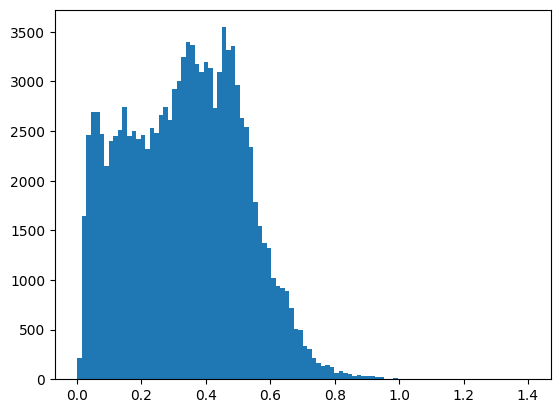

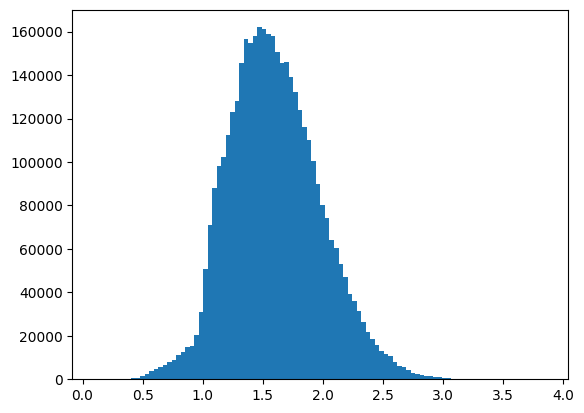

In [262]:
# Compare distribution of distances for similar and dissimilar pairs
plt.hist(u_dist[sim_notsame].detach().numpy(), bins=100)
plt.show()
plt.hist(u_dist[~similarity_mask].detach().numpy(), bins=100)
plt.show()


#### Number of similar expressions

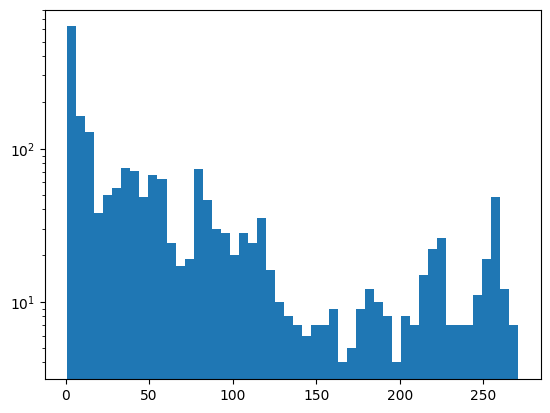

In [274]:
plt.hist(similarity_mask.sum(dim=1).detach().numpy(), bins=50)
plt.yscale('log')
plt.show()

In [275]:
torch.where(similarity_mask.sum(dim=1) > 200)


(tensor([   0,    8,   11,   22,   40,   66,   87,   91,   92,   95,   99,  121,
          129,  149,  177,  189,  202,  213,  222,  224,  248,  251,  268,  277,
          279,  287,  306,  311,  333,  359,  375,  385,  393,  400,  404,  409,
          427,  446,  449,  450,  452,  455,  461,  462,  474,  497,  504,  507,
          545,  552,  554,  585,  589,  602,  611,  621,  632,  636,  639,  647,
          653,  669,  689,  692,  693,  696,  698,  700,  709,  713,  718,  724,
          768,  773,  775,  785,  786,  808,  820,  823,  824,  829,  834,  845,
          850,  851,  852,  866,  867,  870,  893,  903,  936,  938,  940,  947,
          951,  983,  987, 1027, 1034, 1114, 1122, 1138, 1155, 1165, 1178, 1198,
         1204, 1206, 1221, 1232, 1245, 1254, 1260, 1264, 1275, 1303, 1304, 1312,
         1313, 1327, 1337, 1338, 1341, 1345, 1354, 1360, 1376, 1384, 1406, 1409,
         1417, 1425, 1434, 1440, 1446, 1457, 1462, 1481, 1482, 1486, 1498, 1501,
         1504, 1531, 1544, 1

#### Analysing single target (similar to above)

258
Similar expression indices: tensor([   0,    8,   11,   22,   40,   48,   66,   79,   87,   91,   92,   95,
          99,  111,  121,  129,  132,  149,  150,  156,  177,  189,  202,  213,
         222,  224,  227,  248,  251,  259,  268,  277,  278,  279,  287,  289,
         306,  308,  311,  333,  359,  369,  375,  385,  393,  400,  404,  409,
         427,  446,  449,  450,  452,  455,  461,  462,  470,  474,  497,  499,
         504,  507,  510,  526,  530,  545,  552,  554,  560,  585,  589,  602,
         604,  611,  621,  632,  636,  639,  647,  653,  668,  669,  674,  679,
         689,  692,  693,  696,  697,  698,  700,  709,  713,  718,  724,  756,
         759,  768,  773,  775,  785,  786,  808,  820,  823,  824,  829,  834,
         845,  850,  851,  852,  856,  859,  866,  867,  870,  881,  893,  899,
         903,  910,  936,  938,  940,  947,  951,  983,  987, 1027, 1034, 1074,
        1114, 1122, 1138, 1155, 1165, 1173, 1178, 1198, 1204, 1206, 1221, 1223,
        

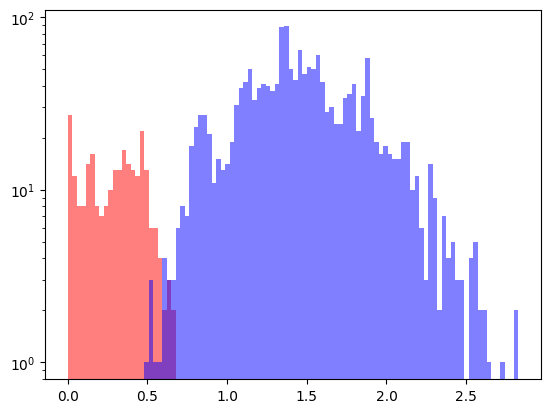

In [276]:
i = 87  # Target index

a = similarity_mask[i, :]
print(a.sum().item())
print(f'Similar expression indices: {torch.where(a)[0]}')

plt.hist(u_dist[i, a].detach().numpy(), bins=100, range=(0, u_dist[i, :].max().item()), color='r', alpha=0.5)
plt.hist(u_dist[i, ~a].detach().numpy(), bins=100, range=(0, u_dist[i, :].max().item()), color='b', alpha=0.5)
plt.yscale('log')
plt.show()

### 2.3 Find communities of similar expressions to target in latent space

In [10]:
similar_indices = np.where(y_dist < SIMILARITY_THRESHOLD)[0][:1000]  # Cap at 1000 samples

In [11]:
x_sim = torch.stack([data_from_loader(train_loader, 'x', idx=i) for i in similar_indices])
z_sim = model.encoder(x_sim)[0]

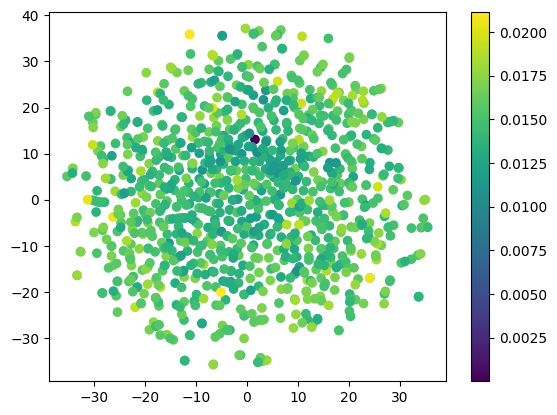

In [12]:
from sklearn.manifold import TSNE

# Run t-SNE to reduce dimensionality from 32D to 2D
tsne = TSNE(n_components=2, random_state=42)
z_sim_2d = tsne.fit_transform(z_sim.detach().numpy())

plt.scatter(z_sim_2d[:, 0], z_sim_2d[:, 1], c=z_dist[similar_indices, 0], cmap='viridis')
plt.colorbar()
plt.show()

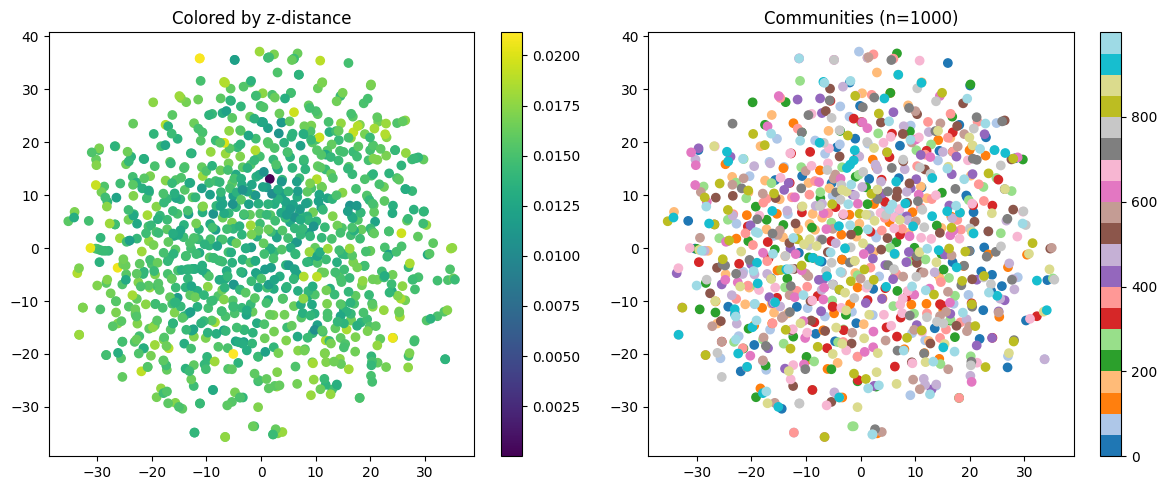

Number of communities detected: 1000


In [13]:
# Run community detection using python-louvain (community)
import community.community_louvain as community_louvain
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances

# Calculate pairwise distances between latent vectors
distances = euclidean_distances(z_sim.detach().numpy())

# Convert distances to similarities (using negative exponential)
similarities = np.exp(-distances**2)

# Create networkx graph from similarity matrix
G = nx.from_numpy_array(similarities)

# Run Louvain community detection
communities_dict = community_louvain.best_partition(G)
communities = np.array([communities_dict[i] for i in range(len(G))])

# Plot the t-SNE embedding colored by communities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Original plot with z-distances
scatter1 = ax1.scatter(z_sim_2d[:, 0], z_sim_2d[:, 1], c=z_dist[similar_indices, 0], cmap='viridis')
ax1.set_title('Colored by z-distance')
plt.colorbar(scatter1, ax=ax1)

# New plot with communities
scatter2 = ax2.scatter(z_sim_2d[:, 0], z_sim_2d[:, 1], c=communities, cmap='tab20')
ax2.set_title(f'Communities (n={len(np.unique(communities))})')
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

print(f"Number of communities detected: {len(np.unique(communities))}")


## 2.3 Using above plots to get a sense for contrastive loss

## Parsing test

In [ ]:
logits_to_prods(logits, GCFG, sample=sample, replace_const=replace_const, round_const_decimals=round_const_decimals)

In [9]:
grammar

"\nS -> 'ADD' S S | 'SUB' S S | 'MUL' S S | 'DIV' S S\nS -> 'SIN' S | 'COS' S | 'EXP' S | 'TANH' S | 'COSH' S | 'SINH' S\nS -> 'CON'\nS -> 'x1' \nEND -> 'END'\n"

In [19]:
from src.model.parsing import logits_to_prods
from src.model.grammar import grammar, S
from src.model.util import load_config
from nltk import CFG, Nonterminal


GCFG = CFG.fromstring(grammar)
cfg = load_config('../model/config.yaml')

batch_size = 1
syntax_shape = (batch_size, cfg.model.io_format.seq_len, cfg.model.io_format.token_cnt)
x = torch.randn(syntax_shape)
logits_prods = x[:, :-1]
constants = x[:, -1]

prods = logits_to_prods(x.squeeze(), GCFG, start_symbol=S, sample=False)


In [34]:
from src.model.grammar import masks, allowed_prod_idx


print(masks)
print(allowed_prod_idx)

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False,  True]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])


In [30]:
from src.model.grammar import get_mask
from src.model.util import Stack

stack = Stack(grammar=GCFG, start_symbol=S)
alpha = stack.pop()  # Alpha is notation in paper: current LHS token
mask = get_mask(alpha, GCFG, as_variable=True)
mask

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.])

In [22]:
prods[0].lhs

<bound method Production.lhs of S -> 'COSH' S>

In [18]:
from src.model.parsing import logits_to_infix

infix = logits_to_infix(x.squeeze())
infix


'((TANH((-0.3067088723182678)/((COS(x1)+(COS((TANH(SIN(COSH(S)*S)))+S)))+S)))/S)/S'

In [37]:
grammar = """
S -> 'ADD' S S | 'SUB' S S | 'MUL' S S | 'DIV' S S
S -> 'SIN' S | 'COS' S | 'EXP' S | 'TANH' S | 'COSH' S | 'SINH' S
S -> 'CON'
S -> 'x1' 
END -> 'END'
"""

# grammar = """
# S -> 'ADD' S S | 'SUB' S S | 'MUL' S S | 'DIV' S S
# S -> 'COS' S | 'EXP' S
# S -> 'CON'
# S -> 'x1' 
# END -> 'END'
# """

GCFG = CFG.fromstring(grammar)
S = Nonterminal('S')
MAX_LEN, DIM = 15, 9  # FIXME: use config

# Collect all lhs symbols, and the unique set of them
all_lhs = [prod.lhs().symbol() for prod in GCFG.productions()]
unique_lhs = []
[unique_lhs.append(x) for x in all_lhs if x not in unique_lhs]

# Rhs symbol indices for each production rule
rhs_map = []
for prod in GCFG.productions():  # [S -> 'ADD' S S]
    tmp = []
    for prod_target in prod.rhs():  # ['ADD', S, S]
        if not isinstance(prod_target, str):  # S
            s = prod_target.symbol()  # 'S'
            tmp.extend(list(np.where(np.array(unique_lhs) == s)[0]))  # [1]
    rhs_map.append(tmp)

# For each lhs symbol which productions rules should be masked
masks = np.array([np.array([lhs == symbol for lhs in all_lhs], dtype=bool).reshape(1, -1) for symbol in unique_lhs]).squeeze()
masks.shape

(2, 13)

In [38]:
def logits_to_prods(logits, grammar, start_symbol: Nonterminal = S, sample=False, max_length=15):
    stack = Stack(grammar=grammar, start_symbol=start_symbol)

    logits_prods = logits[:, :-1]
    constants = logits[:, -1]

    prods = []
    t = 0  # "Time step" in sequence
    j = 0  # Index of constant
    while stack.nonempty:
        alpha = stack.pop()  # Alpha is notation in paper: current LHS token
        mask = get_mask(alpha, grammar, as_variable=True)
        probs = mask * logits_prods[t].exp()
        assert (tot := probs.sum()) > 0, f"Sum of probs is 0 at t={t}. Probably due to bad mask or invalid logits?"
        probs = probs / tot

        if sample:
            m = Categorical(probs)
            i = m.sample()
        else:
            _, i = probs.max(-1) # argmax

        # select rule i
        rule = grammar.productions()[i.item()]

        # If rule has -> [CONST] add const
        rule = Production(lhs=rule.lhs(), rhs=(str(constants[t].item()),))

        prods.append(rule)
        # add rhs nonterminals to stack in reversed order
        for symbol in reversed(rule.rhs()):
            if isinstance(symbol, Nonterminal):
                stack.push(symbol)
        t += 1
        if t == max_length:
            break
    return prods

<Grammar with 13 productions>